# Comparison of tre-based algorithms

So far in the XBT work, decision trees have shown themselves to be almost as good (based on the chosen classification metrics) as random forests.There are variety of flavours of tree based algorithms available, from the simple decision tree, to random forests and gradient boosted trees. The purpose of this notebook is to compare classification accuracy between different flavours of decision tree.

In [5]:
import os
import sys
import pathlib
import functools
import itertools
import datetime
import random

In [6]:
import pandas
import numpy

In [7]:
import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [8]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.pyplot.style.use('ggplot')

In [9]:
import ipywidgets
import time

In [10]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble

In [11]:
import xgboost

In [12]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [13]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [14]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'
print(environment)

local


In [15]:
try:
    root_data_dir = os.environ['XBT_ROOT_DIR']
except KeyError:
    root_data_dir = '/data/users/shaddad/xbt-data/',
    
year_range = (1966,2015)
print(root_data_dir)
print(year_range)

/Users/stephen.haddad/data/xbt-data/
(1966, 2015)


In [124]:
plots_dir = pathlib.Path(root_data_dir) / 'plots'
if not plots_dir.is_dir():
    plots_dir.mkdir()

In [16]:
metrics_avg = 'weighted'
cv_metric_names = [f'recall_{metrics_avg}', f'precision_{metrics_avg}', f'f1_{metrics_avg}']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']
target_feature_name = 'instrument'

In [17]:
splitter_features = ['year', 'instrument']
test_feature = 'cruise_number'
ensemble_test_fraction = 0.1
num_test_splits = 5
test_fraction = 1.0 / num_test_splits
num_train_splits = 5
train_fraction = 1.0 - (1.0 / num_train_splits)
test_fold_name = 'test_fold'

In [18]:
input_dir_name = 'dask_clean'
exp_out_dir_name = 'experiment_outputs'

In [19]:
experiment_name = 'nb_single_decisionTree_country'
classifier_name = 'decision_tree'
suffix='countryAndLatLon'

In [20]:
classifier_opts = {'decision_tree' :
                   {
                       'opts': {'max_depth': 20,
                                'min_samples_leaf': 1,
                                'criterion': 'gini'
                              },
                       'class': sklearn.tree.DecisionTreeClassifier,
                   },
                   'random_forest': {
                       'opts':  {'max_depth': 20,
                                'min_samples_leaf': 1,
                                'criterion': 'gini'
                                },
                       'class': sklearn.ensemble.RandomForestClassifier,
                   },
                   'xbgoost': {
                       'opts':  {'objective':'binary:logistic', 
                                 'n_estimators':2},
                       'class': xgboost.XGBClassifier,
                   },
                  }



In [21]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [22]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /Users/stephen.haddad/data/xbt-data/experiment_outputs/nb_single_decisionTree_country


In [23]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [24]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 6.04 s, sys: 1.45 s, total: 7.49 s
Wall time: 7.58 s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [25]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 231 ms, sys: 88.3 ms, total: 319 ms
Wall time: 319 ms


In [26]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [27]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [28]:
%%time
test_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)
test_var_name = 'test'
test_part_name = 'test_part'
test_whole_name = 'test_whole'
test_indices = list(itertools.chain.from_iterable([list(xbt_labelled.filter_obs({target_feature_name: selected_instrument}).xbt_df.sample(frac=0.1).index) 
for selected_instrument in xbt_labelled['instrument'].unique()]))

CPU times: user 1.19 s, sys: 54.8 ms, total: 1.24 s
Wall time: 1.24 s


In [29]:
# label test data based on whole cruises set aside
xbt_labelled.xbt_df[test_var_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)
xbt_labelled.xbt_df[test_whole_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)

In [30]:
# label test data where part of the cruise is in the train/validation sets
xbt_labelled.xbt_df.loc[test_indices, test_var_name] = True
xbt_labelled.xbt_df[test_part_name] = False
xbt_labelled.xbt_df.loc[test_indices, test_part_name] = True


In [31]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [32]:
imeta_feature_name = f'{target_feature_name}_imeta'

In [33]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 
xbt_labelled.xbt_df[imeta_feature_name] = imeta_instrument
xbt_labelled._target_encoders[imeta_feature_name] = xbt_labelled._target_encoders[target_feature_name]
xbt_labelled._feature_encoders[imeta_feature_name] = xbt_labelled._feature_encoders[target_feature_name]

In [34]:
%%time
xbt_test = xbt_labelled.filter_obs({test_var_name: True})
xbt_working = xbt_labelled.filter_obs({test_var_name: False})

CPU times: user 109 ms, sys: 27.3 ms, total: 136 ms
Wall time: 135 ms


get separate sets of 2 types of validation data.
* data from cruises where the whole cruise is in the validation data 
* data where some of the profiles are in the training data

In [35]:
xbt_test_whole = xbt_labelled.filter_obs({test_whole_name: True})
xbt_test_part = xbt_labelled.filter_obs({test_part_name: True})

In [36]:
X_working_all = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_working_all = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]

In [37]:
X_test_all = xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_test_all = xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0]

## Resampling

In [38]:
num_resamples_per_class = 25000

In [39]:
instrument_sample_list = [instrument1 for instrument1, count1 in zip(xbt_labelled.xbt_df[target_feature_name].value_counts().index, xbt_labelled.xbt_df[target_feature_name].value_counts()) if count1 > 100] 


In [40]:
def get_resampled(instrument_list, xbt_subset1, resample_index, random_state, num_samples):
    resampled_profiles_list = [xbt_subset1.filter_obs({target_feature_name: ins1}).xbt_df.sample(
        num_samples, 
        replace=True,
        random_state=random_state,
    ) 
         for ins1 in instrument_list]
    resampled_training_indices = list(set(itertools.chain.from_iterable([list(rp1.index) for rp1 in resampled_profiles_list])))
    if resample_index is None:
        resample_index = 0
    resample_feature_name = f'resample_train_{resample_index}'
    xbt_subset1.xbt_df[resample_feature_name] = xbt_subset1.xbt_df.index.isin(resampled_training_indices)
    resampled_df = pandas.concat(
        resampled_profiles_list,
        ignore_index=True,
    )
    xbt_resampled_train_all = XbtDataset(xbt_input_dir, year_range, df=resampled_df)
    xbt_resampled_train_all._feature_encoders = xbt_labelled._feature_encoders
    xbt_resampled_train_all._arget_encoders = xbt_labelled._target_encoders
    return xbt_resampled_train_all

In [41]:
xbt_train, xbt_validate = xbt_working.train_test_split(
    train_fraction=0.8,
    refresh=True,                            
)

In [42]:
xbt_train.shape, xbt_validate.shape

((689290, 21), (172323, 21))

In [43]:
X_train_all = xbt_train.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train.filter_features([target_feature_name]).get_ml_dataset()[0]

In [44]:
X_validate_all = xbt_validate.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_validate_all = xbt_validate.filter_features([target_feature_name]).get_ml_dataset()[0]

In [73]:
%%time
clf_dict_resampled = {clf_name: {} for clf_name in classifier_opts.keys()}
for ix1 in range(num_train_splits):
    xbt_resampled_train_all = get_resampled(
        instrument_sample_list, 
        xbt_train, 
        resample_index=0,
        random_state=int((datetime.datetime.now().timestamp()*1e5) % 1e5),
        num_samples=num_resamples_per_class,
    )    
    for clf_name, clf_params in classifier_opts.items():
        print(clf_name)
        clf_dt1 = clf_params['class'](**clf_params['opts'])
        clf_dt1.fit(
            xbt_train.filter_features(input_feature_names).get_ml_dataset()[0], 
            xbt_train.filter_features([target_feature_name]).get_ml_dataset()[0],
        )        
        clf_dict_resampled[clf_name][f'{clf_name}_resampled_{ix1}'] = clf_dt1


decision_tree
random_forest
xbgoost
[16:29:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
decision_tree
random_forest
xbgoost
[16:31:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
decision_tree
random_forest
xbgoost
[16:33:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
decision_tree
random_forest
xbgoost
[16:35:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation met

# Cross-validation based ensemble on imbalanced data

In [46]:
%%time
xbt_working.generate_folds_by_feature('cruise_number', num_test_splits, test_fold_name)

CPU times: user 18.5 s, sys: 93.9 ms, total: 18.6 s
Wall time: 18.1 s


In [47]:
cruise_numbers = list(xbt_working['cruise_number'].unique())

In [48]:
X_labelled = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]


In [49]:
%%time
scores = {}
for clf_name, clf_params in classifier_opts.items():
    print(clf_name)
    group_cv1 = sklearn.model_selection.KFold(n_splits=num_test_splits,
                                              shuffle=True,
                                              random_state=random.randint(1,2**20))
    
    clf_dt1 = clf_params['class'](**clf_params['opts'])
    scores[clf_name] = sklearn.model_selection.cross_validate(
        clf_dt1,
        X_labelled, y_labelled, 
        groups=xbt_working[test_fold_name], 
        cv=group_cv1,
        return_estimator=True,
        return_train_score=True,
        scoring=cv_metric_names,
        n_jobs=-1,
    )

decision_tree
random_forest
xbgoost
CPU times: user 3.87 s, sys: 6.06 s, total: 9.92 s
Wall time: 5min 13s


### Calculating ensemble outputs

TODO:
* get gradient boosting classifier to work
* get xgboost classifier to work
* calculate recall metrics for each of the classifiers
* compare the ensemble output with the predict proba output from random forest and gradient boosted classifiers
* create plots showing recall for different decision tree based options

In [50]:
calc_disagreements = lambda x: len(set(x))

/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stephen.haddad/opt/anaconda3/envs/xbt_env_xgboost/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [66]:
def calc_ensemble_output(xbt_subset, clf_dict, instrument_list, target_name, input_names, target_encoder):
    d1 = {
    f'{target_name}_{clf_name}_res': 
    xbt_subset._feature_encoders[target_feature_name].inverse_transform(
        clf1.predict(xbt_test.filter_features(input_names).get_ml_dataset()[0]))
    for clf_name, clf1 in clf_dict.items()
    }
    ens_features = list(d1.keys())
    d1['id'] = xbt_subset['id']
    instr_predictions = pandas.DataFrame(d1)
    probs_instrument = functools.reduce(
        lambda x,y: x+y, 
        [target_encoder.transform(instr_predictions[[pred1]])
         for pred1 in ens_features
         ]) / len(ens_features)
    probs_instrument_df = pandas.DataFrame({
        col_name: probs_instrument[:,col_ix1]
        for col_ix1, col_name in enumerate(instrument_list)
    })    
    max_prob_ensemble = probs_instrument_df.idxmax(axis='columns')
    return {
        'ens_features': ens_features, 
        'instr_predictions': instr_predictions, 
        'probs_instrument': probs_instrument_df, 
        'max_prob_ensemble': max_prob_ensemble} 
    
    

In [64]:
clf_dict_cv = {clf_name: {f'{clf_name}_{ix1}': clf1 for ix1, clf1 in enumerate(score_clf['estimator'])} for clf_name, score_clf in scores.items()}

In [56]:
instrument_list = list(xbt_labelled._feature_encoders[target_feature_name].classes_)

In [68]:
%%time
ensemble_results_cv = {
    clf_name: calc_ensemble_output(xbt_subset=xbt_test,
                                   clf_dict=clf_dict1,
                                   instrument_list=instrument_list,
                                   target_name=target_feature_name,
                                   input_names=input_feature_names,
                                   target_encoder=xbt_labelled._target_encoders[target_feature_name],
                                   )
    for clf_name, clf_dict1  in clf_dict_cv.items()
}

Calculate ensemble outputs for resampled data.

In [74]:
%%time
ensemble_results_resampled = {
    clf_name: calc_ensemble_output(xbt_subset=xbt_test,
                                   clf_dict=clf_dict1,
                                   instrument_list=instrument_list,
                                   target_name=target_feature_name,
                                   input_names=input_feature_names,
                                   target_encoder=xbt_labelled._target_encoders[target_feature_name],
                                   )
    for clf_name, clf_dict1  in clf_dict_resampled.items()
}

CPU times: user 29.1 s, sys: 2.75 s, total: 31.8 s
Wall time: 23.1 s


## Calculate metrics

In [75]:
def calc_metric_subset(xbt_subset, clf1, filter_dict, inputs, target_feature, metric_func, metric_args_dict):
    if filter_dict:
        xbt_selected = xbt_subset.filter_obs(filter_dict)
    else:
        xbt_selected = xbt_subset
    if xbt_selected.shape[0] == 0:
        return 0.0
    metrics_result = metric_func(
        clf1.predict(xbt_selected.filter_features(inputs).get_ml_dataset()[0]),
        xbt_selected.filter_features([target_feature]).get_ml_dataset()[0],
        **metric_args_dict)
    return metrics_result                       

In [76]:
do_avg_args_dict = {'labels':list(range(0,len(instrument_list))), 
                    'average':'weighted'}
metrics_defs_dict = {
    'recall': {'metric_func': sklearn.metrics.recall_score, 'metric_args_dict': do_avg_args_dict},
    'precision': {'metric_func': sklearn.metrics.precision_score, 'metric_args_dict': do_avg_args_dict},
    'accuracy': {'metric_func': sklearn.metrics.accuracy_score, 'metric_args_dict': {}},
    'f1': {'metric_func': sklearn.metrics.f1_score, 'metric_args_dict': do_avg_args_dict},
    'balanced_accuracy': {'metric_func': sklearn.metrics.balanced_accuracy_score, 'metric_args_dict': {}},    
}


In [77]:
metrics_imeta_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test.filter_features([f'{target_feature_name}_imeta']).get_ml_dataset()[0],
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_imeta_all['classifier'] = 'imeta'

In [83]:
%%time
metrics_test_resampled_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) 
    for clf_name, clf_dict1 in clf_dict_resampled.items() 
    for res_ix1, clf1 in clf_dict1.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_resampled_ens['classifier'] = [
    f'resampled_{clf_name}_{res_ix1}' 
    for clf_name, clf_dict1 in clf_dict_resampled.items() 
    for res_ix1, clf1 in clf_dict1.items()]


CPU times: user 2min 28s, sys: 8.13 s, total: 2min 36s
Wall time: 1min 48s


In [86]:
%%time
metrics_test_cv_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) 
    for clf_name, clf_dict1 in clf_dict_cv.items() 
    for res_ix1, clf1 in clf_dict1.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_cv_ens['classifier'] = [
    f'cv_{res_ix1}' 
    for clf_name, clf_dict1 in clf_dict_cv.items() 
    for res_ix1, clf1 in clf_dict1.items()]

CPU times: user 2min 31s, sys: 11.3 s, total: 2min 42s
Wall time: 1min 56s


In [87]:
metrics_all_classifiers = pandas.concat([
    metrics_test_resampled_ens,
    metrics_test_cv_ens,
    pandas.DataFrame.from_records([metrics_imeta_all]),
])
metrics_all_classifiers 

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.947969,0.949733,0.947969,0.948636,0.688085,resampled_decision_tree_decision_tree_resampled_0
1,0.948188,0.949883,0.948188,0.948840,0.699804,resampled_decision_tree_decision_tree_resampled_1
2,0.948778,0.950492,0.948778,0.949422,0.698186,resampled_decision_tree_decision_tree_resampled_2
3,0.948523,0.950345,0.948523,0.949199,0.695344,resampled_decision_tree_decision_tree_resampled_3
4,0.948428,0.950172,0.948428,0.949098,0.706632,resampled_decision_tree_decision_tree_resampled_4
5,0.957626,0.960661,0.957626,0.958655,0.950083,resampled_random_forest_random_forest_resampled_0
6,0.956882,0.959926,0.956882,0.957913,0.935202,resampled_random_forest_random_forest_resampled_1
7,0.957566,0.960614,0.957566,0.958592,0.937799,resampled_random_forest_random_forest_resampled_2
8,0.957726,0.960597,0.957726,0.958676,0.931570,resampled_random_forest_random_forest_resampled_3
9,0.957412,0.960448,0.957412,0.958410,0.936780,resampled_random_forest_random_forest_resampled_4


In [90]:
%%time
metrics_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for clf_name, clf_dict1 in clf_dict_resampled.items() 
    for res_ix1, clf1 in clf_dict1.items()
}
metrics_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                    for  fn1 in instrument_list]
metrics_raw_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_resampled_df = pandas.DataFrame(metrics_raw_dict)
metrics_per_class_resampled_df = metrics_per_class_resampled_df.sort_values('num_profiles', ascending=False)

for metric_name in metrics_defs_dict.keys(): 
    metrics_per_class_resampled_df[f'{metric_name}_instr_avg'] = metrics_per_class_resampled_df[[c1 for c1 in metrics_per_class_resampled_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 7min 30s, sys: 16.8 s, total: 7min 47s
Wall time: 3min 10s


In [91]:
%%time
metrics_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
                       for metric_name,metric1 in metrics_defs_dict.items() 
                       for clf_name, clf_dict1 in clf_dict_cv.items() 
                       for res_ix1, clf1 in clf_dict1.items()
}
metrics_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                       for fn1 in instrument_list]
metrics_raw_cv_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_cv_df = pandas.DataFrame(metrics_raw_cv_dict)
metrics_per_class_cv_df = metrics_per_class_cv_df.sort_values('num_profiles', ascending=False)
for metric_name in metrics_defs_dict.keys(): 
    metrics_per_class_cv_df[f'{metric_name}_instr_avg'] = metrics_per_class_cv_df[[c1 for c1 in metrics_per_class_cv_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 7min 35s, sys: 15 s, total: 7min 50s
Wall time: 3min 3s


In [92]:
%%time
metrics_annual_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
                           for metric_name,metric1 in metrics_defs_dict.items() 
                           for clf_name, clf_dict1 in clf_dict_resampled.items() 
                           for res_ix1, clf1 in clf_dict1.items()
}
metrics_annual_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] 
                                           for year1 in range(*year_range)]
metrics_annual_raw_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_resampled_df = pandas.DataFrame(metrics_annual_raw_dict)
for metric_name in metrics_defs_dict.keys(): 
    metrics_annual_resampled_df[f'{metric_name}_instr_avg'] = metrics_annual_resampled_df[[c1 for c1 in metrics_annual_resampled_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 11min 21s, sys: 9.91 s, total: 11min 31s
Wall time: 17min


In [93]:
%%time
metrics_annual_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
                              for metric_name,metric1 in metrics_defs_dict.items() 
                              for clf_name, clf_dict1 in clf_dict_cv.items() 
                              for res_ix1, clf1 in clf_dict1.items()
                             }
metrics_annual_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)]
metrics_annual_raw_cv_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_cv_df = pandas.DataFrame(metrics_annual_raw_cv_dict)
for metric_name in metrics_defs_dict.keys(): 
    metrics_annual_cv_df[f'{metric_name}_instr_avg'] = metrics_annual_cv_df[[c1 for c1 in metrics_annual_cv_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 11min 21s, sys: 11 s, total: 11min 32s
Wall time: 15min 6s


In [105]:
%%time
dt_super_ensemble = clf_dict_cv['decision_tree']
dt_super_ensemble.update(clf_dict_resampled['decision_tree'])
ensemble_results_super = {
    'decision_tree': calc_ensemble_output(xbt_subset=xbt_test,
                                   clf_dict=dt_super_ensemble,
                                   instrument_list=instrument_list,
                                   target_name=target_feature_name,
                                   input_names=input_feature_names,
                                   target_encoder=xbt_labelled._target_encoders[target_feature_name],
                                   )
}

CPU times: user 1.92 s, sys: 578 ms, total: 2.5 s
Wall time: 2.54 s


In [111]:
recall_comparison_dict = []

In [112]:
recall_comparison_dict += [{'name': 'Recall max prob meta-ensemble',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                    xbt_labelled._feature_encoders[target_feature_name].transform(ensemble_results_super['decision_tree']['max_prob_ensemble']),
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]

In [113]:
for clf_name, ens_res1 in  ensemble_results_resampled.items():
    recall_comparison_dict += [{'name': f'Recall max prob resampled {clf_name}',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                xbt_labelled._feature_encoders[target_feature_name].transform(ens_res1['max_prob_ensemble']),
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]

In [114]:
for clf_name, ens_res1 in  ensemble_results_cv.items():
    recall_comparison_dict += [{'name': f'Recall max prob k-fold {clf_name}',
                                'recall_instr': 
                                metrics_defs_dict['recall']['metric_func'](
                                    xbt_labelled._feature_encoders[target_feature_name].transform(ens_res1['max_prob_ensemble']),
                                    xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                    **metrics_defs_dict['recall']['metric_args_dict']
                                )}]

In [115]:
recall_comparison_dict += [{'name': 'Recall iMeta',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                xbt_test.filter_features(['instrument_imeta']).get_ml_dataset()[0],
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]


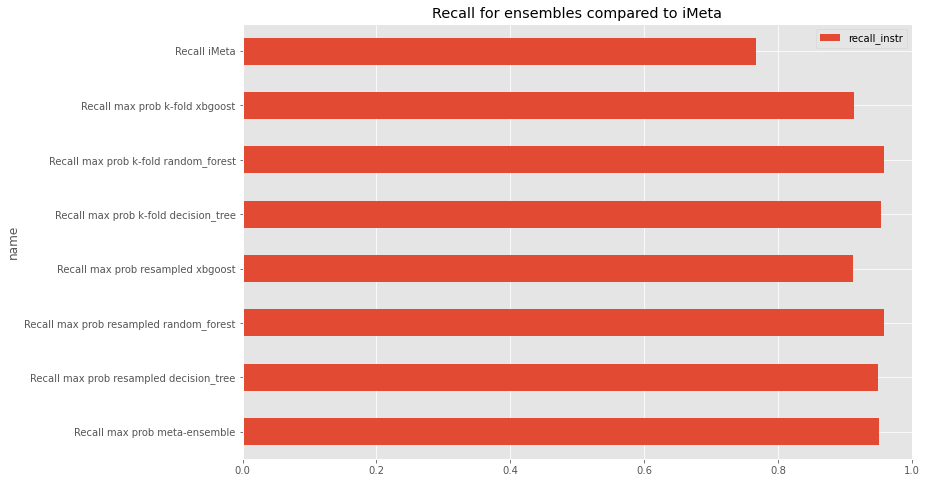

In [125]:
fig1 = matplotlib.pyplot.figure('recall_comparison',figsize=(12,8))
ax1 = fig1.add_subplot(1,1,1, title='Recall for ensembles compared to iMeta')
pandas.DataFrame(recall_comparison_dict).plot.barh(x='name', 
                                                   y='recall_instr',
                                                   xlim=(0.0,1.0),
                                                   ax=ax1
                                                  )
fig1.savefig(plots_dir / 'recall_maxProb_ensembles_imeta.png',
            bbox_inches='tight')

## Plotting metrics

In [126]:
metrics_all_classifiers

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.947969,0.949733,0.947969,0.948636,0.688085,resampled_decision_tree_decision_tree_resampled_0
1,0.948188,0.949883,0.948188,0.948840,0.699804,resampled_decision_tree_decision_tree_resampled_1
2,0.948778,0.950492,0.948778,0.949422,0.698186,resampled_decision_tree_decision_tree_resampled_2
3,0.948523,0.950345,0.948523,0.949199,0.695344,resampled_decision_tree_decision_tree_resampled_3
4,0.948428,0.950172,0.948428,0.949098,0.706632,resampled_decision_tree_decision_tree_resampled_4
5,0.957626,0.960661,0.957626,0.958655,0.950083,resampled_random_forest_random_forest_resampled_0
6,0.956882,0.959926,0.956882,0.957913,0.935202,resampled_random_forest_random_forest_resampled_1
7,0.957566,0.960614,0.957566,0.958592,0.937799,resampled_random_forest_random_forest_resampled_2
8,0.957726,0.960597,0.957726,0.958676,0.931570,resampled_random_forest_random_forest_resampled_3
9,0.957412,0.960448,0.957412,0.958410,0.936780,resampled_random_forest_random_forest_resampled_4


<AxesSubplot:title={'center':'F1 for all data in splits'}, ylabel='classifier'>

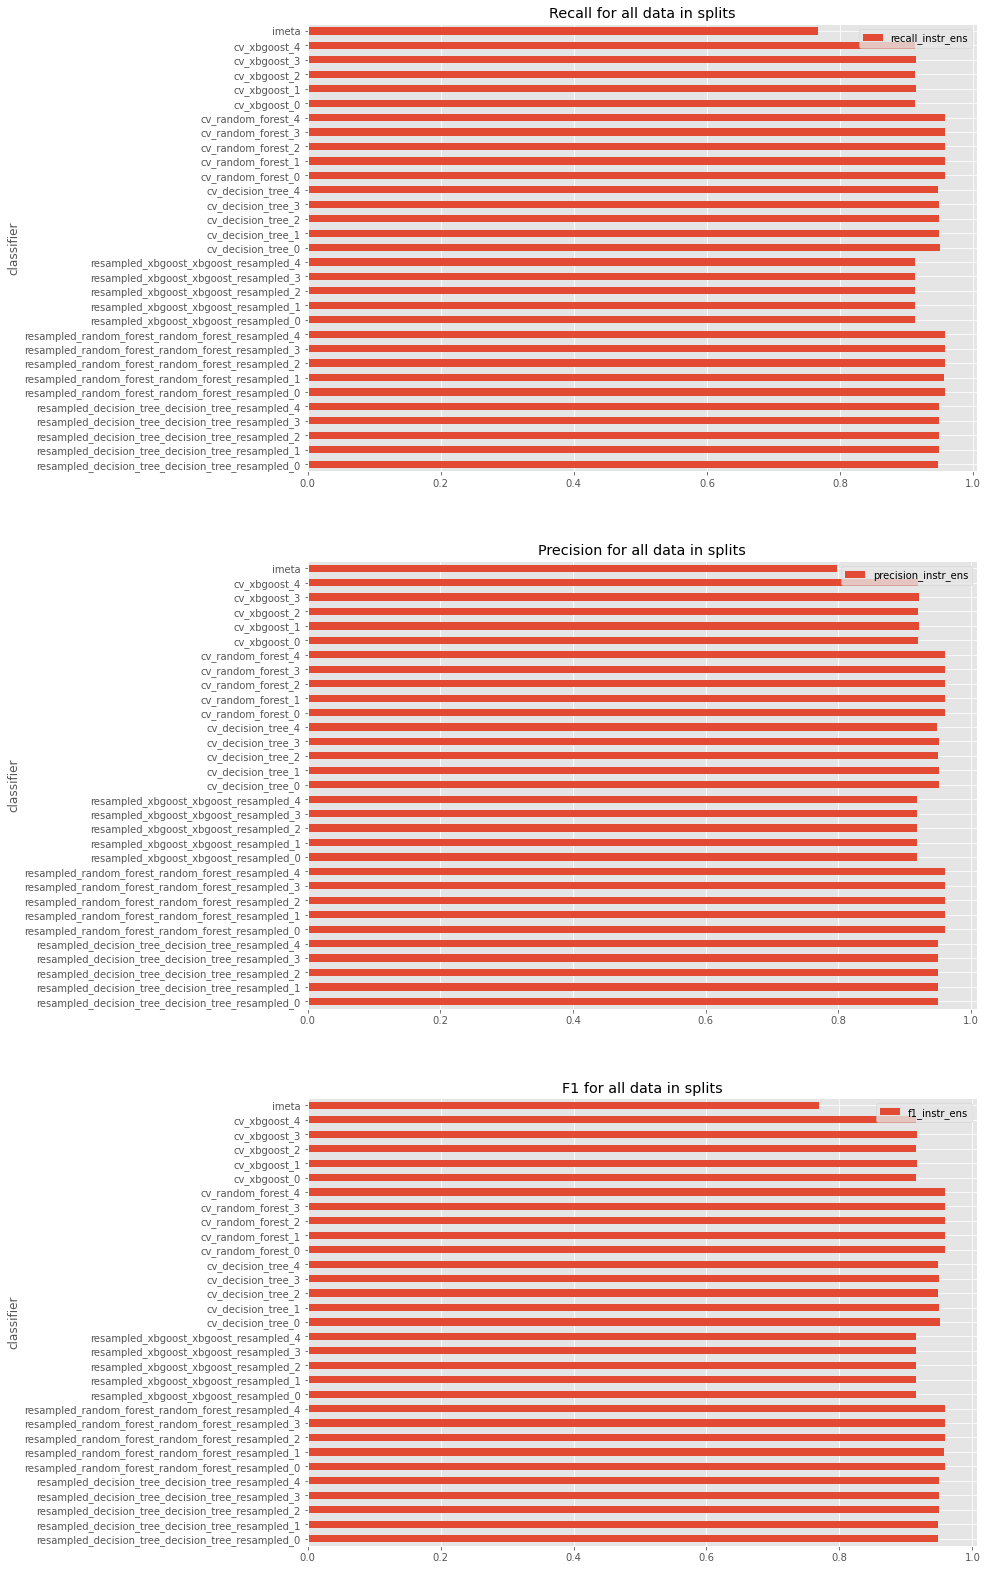

In [129]:
fig1 = matplotlib.pyplot.figure('imbalanced_metrics_all', figsize=(12,28))
ax1 = fig1.add_subplot(3,1,1,title='Recall for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='recall_instr_ens', ax=ax1)
ax1 = fig1.add_subplot(3,1,2,title='Precision for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='precision_instr_ens', ax=ax1)
ax1 = fig1.add_subplot(3,1,3,title='F1 for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='f1_instr_ens', ax=ax1)

In [130]:
metrics_per_class_cv_df_plot = metrics_per_class_cv_df[[(xbt_test.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_cv_df['instrument']]]
metrics_per_class_resampled_df_plot = metrics_per_class_resampled_df[[(xbt_test.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_resampled_df['instrument']]]

In [131]:
metrics_per_class_cv_df[['recall_instr_avg', 'instrument', 'num_profiles']]

,recall_instr_avg,instrument,num_profiles
9,0.974987,XBT: T4 (SIPPICAN),448238
2,0.974166,XBT: DEEP BLUE (SIPPICAN),305512
15,0.860239,XBT: T7 (SIPPICAN),192456
6,0.873917,XBT: T10 (SIPPICAN),41666
16,0.906468,XBT: T7 (TSK - TSURUMI SEIKI Co.),17588
14,0.913989,XBT: T6 (TSK - TSURUMI SEIKI Co.),15559
11,0.756323,XBT: T5 (SIPPICAN),14413
10,0.940292,XBT: T4 (TSK - TSURUMI SEIKI Co.),7685
13,0.618895,XBT: T6 (SIPPICAN),5986
4,0.833510,XBT: FAST DEEP (SIPPICAN),4481


In [133]:
table_comparison_classes = pandas.DataFrame({'instrument': metrics_per_class_cv_df['instrument'], 
                  'recall_imbalanced': metrics_per_class_cv_df['recall_instr_avg'],
                  'recall_resampled': metrics_per_class_resampled_df['recall_instr_avg'],
                  'precision_imbalanced': metrics_per_class_cv_df['precision_instr_avg'],
                  'precision_resampled': metrics_per_class_resampled_df['precision_instr_avg'],
                   'support': metrics_per_class_resampled_df['num_profiles'],
                 })
table_comparison_classes.to_csv(plots_dir / 'per_class_imablancesVsResampled.csv', index=False)

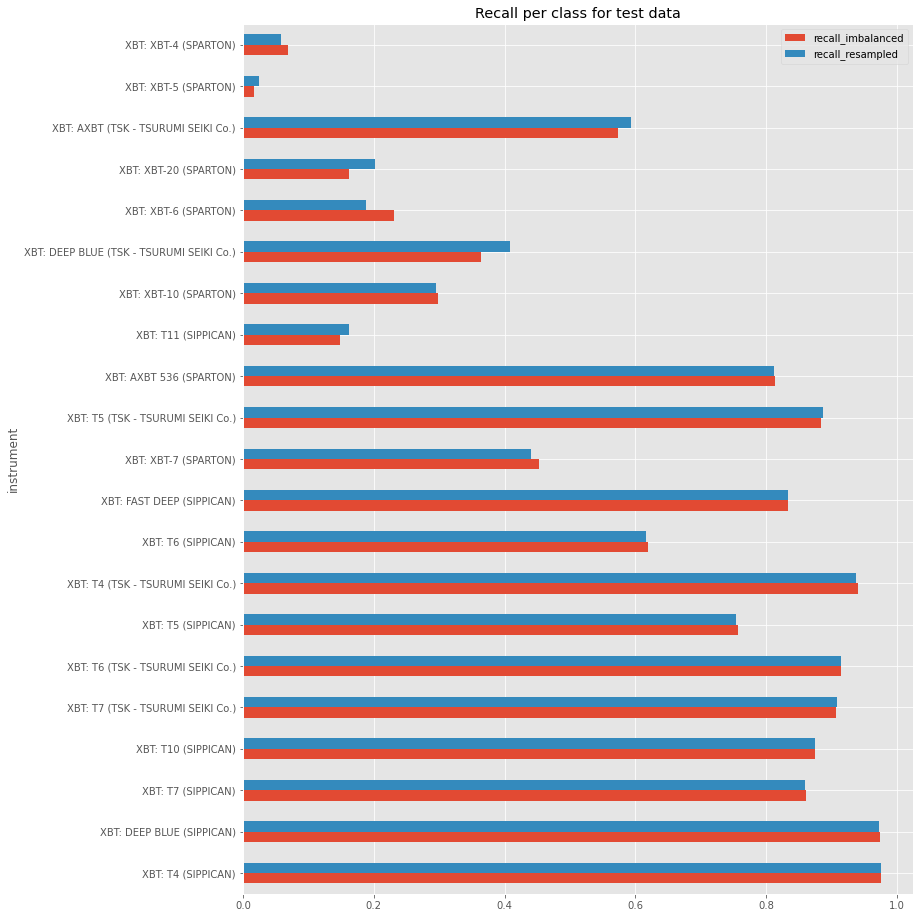

In [134]:
fig1 = matplotlib.pyplot.figure('recall_per_class_test', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='Recall per class for test data')
_ = pandas.DataFrame({'instrument': metrics_per_class_resampled_df_plot['instrument'], 
                  'recall_imbalanced': metrics_per_class_cv_df_plot['recall_instr_avg'],
                  'recall_resampled': metrics_per_class_resampled_df_plot['recall_instr_avg'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig(plots_dir /'recall_test_per_class_imbalancedClf.png', bbox_inches='tight')

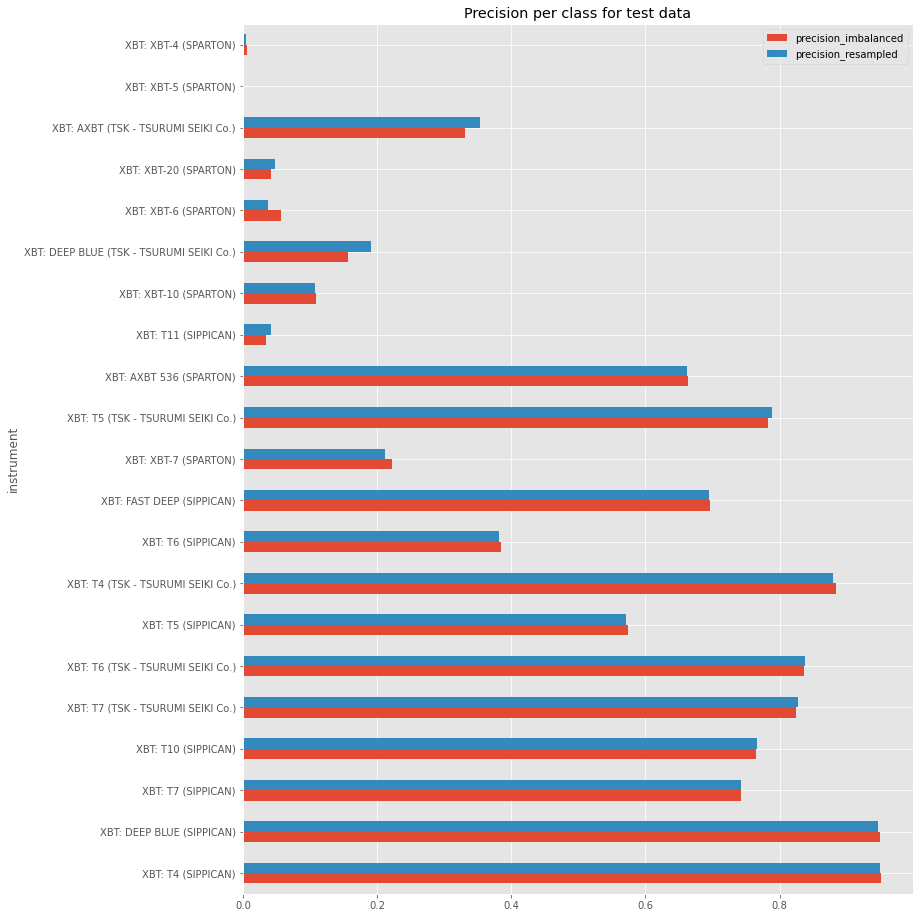

In [135]:
fig1 = matplotlib.pyplot.figure('precision_per_class_test', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='Precision per class for test data')
_ = pandas.DataFrame({'instrument': metrics_per_class_cv_df_plot['instrument'], 
                  'precision_imbalanced': metrics_per_class_cv_df_plot['precision_instr_avg'],
                  'precision_resampled': metrics_per_class_resampled_df_plot['precision_instr_avg'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig(plots_dir / 'precision_test_per_class_imbalancedClf.png', bbox_inches='tight')

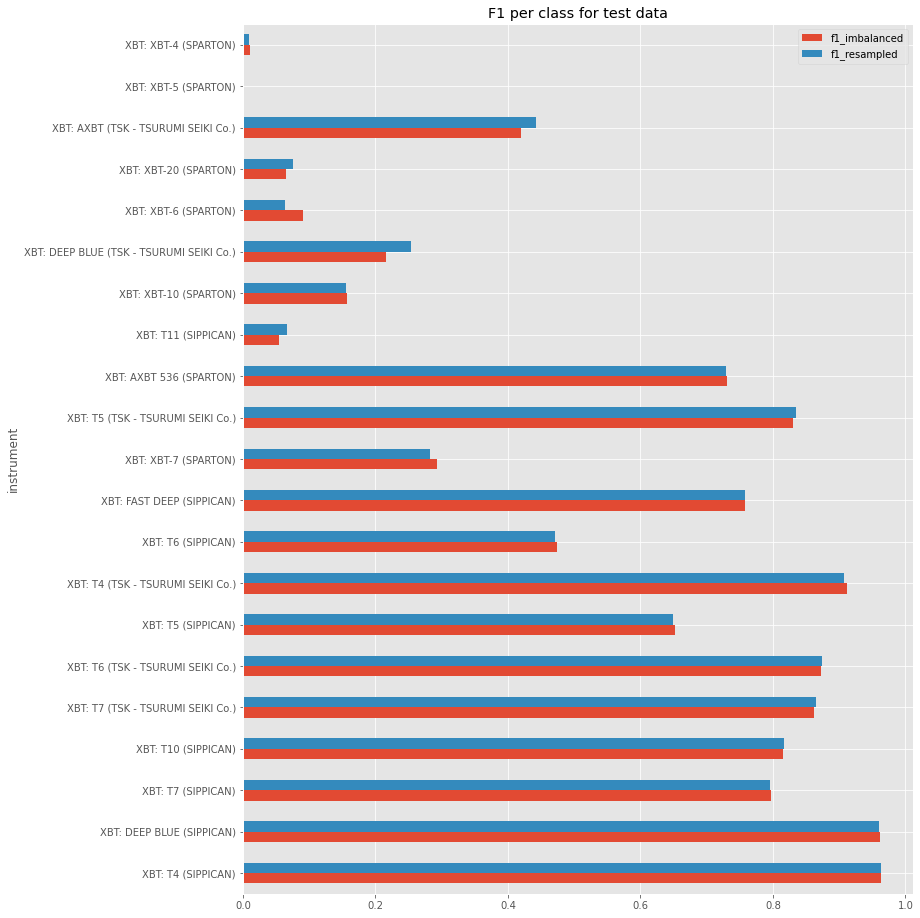

In [136]:
fig1 = matplotlib.pyplot.figure('f1_per_class_test', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='F1 per class for test data')
_ = pandas.DataFrame({'instrument': metrics_per_class_cv_df_plot['instrument'], 
                  'f1_imbalanced': metrics_per_class_cv_df_plot['f1_instr_avg'],
                  'f1_resampled': metrics_per_class_resampled_df_plot['f1_instr_avg'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig(plots_dir / 'f1_test_per_class_imbalancedClf.png', bbox_inches='tight')

In [137]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [141]:
%%time
imeta_results = []
for year in range(year_range[0],year_range[1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='weighted')
    im_acc_instr = sklearn.metrics.accuracy_score(xbt_instr1, y_imeta_instr)
    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                       'imeta_instr_f1': im_f1_instr,
                       'imeta_instr_accuracy': im_acc_instr,
                      }]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [139]:
imeta_results_df = pandas.DataFrame.from_records(imeta_results)

KeyError: 'year'

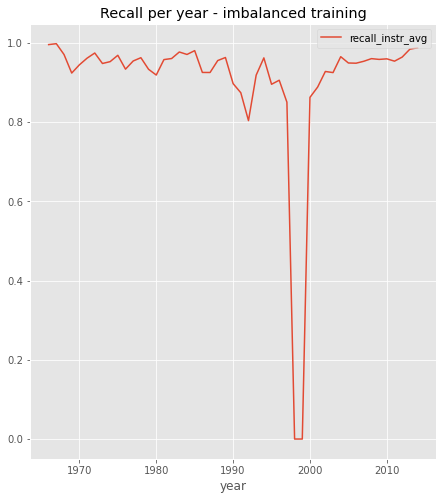

In [140]:
fig1 = matplotlib.pyplot.figure('recall_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='Recall per year - imbalanced training')
metrics_annual_cv_df.plot.line(x='year', y='recall_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_recall', ax=ax1)
ax1.set_ylabel('recall')
ax1 = fig1.add_subplot(1,2,2, title='Recall per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y='recall_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_recall', ax=ax1)
ax1.set_ylabel('recall')
fig1.savefig('/data/users/shaddad/xbt-data/plots/recall_perYear_imbalancedVsResampled.png', bbox_inches='tight')

In [ ]:
fig1 = matplotlib.pyplot.figure('precision_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='precision per year - imbalanced training')
metrics_annual_cv_df.plot.line(x='year', y='precision_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_precision', ax=ax1)
ax1.set_ylabel('precision')
ax1 = fig1.add_subplot(1,2,2, title='precision per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y='precision_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_precision', ax=ax1)
ax1.set_ylabel('precision')
fig1.savefig('/data/users/shaddad/xbt-data/plots/precision_perYear_imbalancedVsResampled.png', bbox_inches='tight')

In [ ]:
fig1 = matplotlib.pyplot.figure('f1_imbalance_resample_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='f1 per year - imbalanced training')
metrics_annual_cv_df.plot.line(x='year', y='f1_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_f1', ax=ax1)
ax1.set_ylabel('f1')
ax1 = fig1.add_subplot(1,2,2, title='f1 per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y='f1_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_f1', ax=ax1)
ax1.set_ylabel('f1')
fig1.savefig('/data/users/shaddad/xbt-data/plots/f1_perYear_imbalancedVsResampled.png', bbox_inches='tight')